## Supplementary Script 1: Basic phylogenetic analysis

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
colors = sns.color_palette()

# path to patient overview file of original cohort (Supplementary Table 1)
overview_fp = 'Supplementary_Table_1.xlsx'
# path to phylogenetic clustering file of original cohort (Supplementary Table 2)
clustering_fp = 'Supplementary_Table_2.xlsx'

col_mono_dm = 'Monophyletic distant mets'
col_mono_lm = 'Monophyletic lymphatic mets'
col_metmono_dm = 'Monophyletic distant mets ALT_CLF'
col_metmono_lm = 'Monophyletic lymphatic mets ALT_CLF'
col_no_dm = 'No distant mets'
col_no_lm = 'No lymphatic mets'
try:
    all_overview_df = pd.read_excel(overview_fp)
    
    # analyze Naxerova cohort (Kim cohort is analyzed separately for Fig. 2)
    overview_df = all_overview_df[all_overview_df.Dataset == 'Naxerova']
except FileNotFoundError:
    print('ERROR: File {} needs to be in the same folder!'.format(overview_fp))
    raise

try:
    clustering_df = pd.read_excel(clustering_fp)
except FileNotFoundError:
    print('ERROR: File {} needs to be in the same folder!'.format(clustering_fp))
    raise

In [3]:
# create dataframe for bar plot depicting the observed frequency of monophyletic clades 
d = defaultdict(list)
for index, row in overview_df.iterrows():
    if not np.isnan(row[col_mono_dm]):
        met_type = 'Distant'
        d['Patient'].append(row.Patient)
        d['MonophyleticClade'].append(True if row[col_mono_dm] == 1 else False)
        d['MetMonophyleticClade'].append(True if row[col_metmono_dm] == 1 else False)
        d['Type'].append(met_type)
        d['NoSamples'].append(clustering_df[(clustering_df.Patient == row.Patient) 
              & (clustering_df['Metastasis type'] == met_type)].m.values[0])
        
    if not np.isnan(row[col_mono_lm]):
        met_type = 'Lymphatic'
        d['Patient'].append(row.Patient)
        d['MonophyleticClade'].append(True if row[col_mono_lm] == 1 else False)
        d['MetMonophyleticClade'].append(True if row[col_metmono_lm] == 1 else False)
        d['Type'].append(met_type)
        d['NoSamples'].append(clustering_df[(clustering_df.Patient == row.Patient) 
              & (clustering_df['Metastasis type'] == met_type)].m.values[0])
        
phyletic_df = pd.DataFrame(data=d)  
print('Mean and median number of lymphatic mets for subjects with at least 2 lymphatic mets: {}, {}'.format(
    np.mean(phyletic_df[(phyletic_df['Type'] == 'Lymphatic')]['NoSamples']), 
    np.median(phyletic_df[(phyletic_df['Type'] == 'Lymphatic')]['NoSamples'])))
print('Mean and median number of distant mets for subjects with at least 2 distant mets: {}, {}'.format(
    np.mean(phyletic_df[(phyletic_df['Type'] == 'Distant')]['NoSamples']), 
    np.median(phyletic_df[(phyletic_df['Type'] == 'Distant')]['NoSamples'])))

Mean and median number of lymphatic mets for subjects with at least 2 lymphatic mets: 3.7, 3.0
Mean and median number of distant mets for subjects with at least 2 distant mets: 3.0, 2.5


In [4]:
def compare_monophyletic_clades(df, col_lm, col_dm, label):
    """
    Investigate the fraction of patients with a monophyletic clade of all lymphatic or distant metastases
    :param df: dataframe with patients and whether there were monophyletic clades
    :param col_lm: name of boolean dataframe column for monophyletic lymphatic mets 
    :param col_dm: name of boolean dataframe column for monophyletic distant mets 
    :param label: what is being investigated
    """
    # 
    dm_mono_frac = len(df[df[col_dm] == 1]) / df[col_dm].count()
    lm_mono_frac = len(df[df[col_lm] == 1]) / df[col_lm].count()

    print('{} of distant metastases: {:.3%} ({}/{})'.format(
        label, dm_mono_frac, len(df[df[col_dm] == 1]), df[col_dm].count()))
    print('{} of lymphatic metastases: {:.3%} ({}/{})'.format(
        label, lm_mono_frac, len(df[df[col_lm] == 1]), df[col_lm].count()))
    oddsratio, pvalue = stats.fisher_exact(
        [[len(df[df[col_dm] == 1]), len(df[df[col_dm] == 0])], 
         [len(df[df[col_lm] == 1]), len(df[df[col_lm] == 0])]])
    print('Probability to observe a more imbalanced ratio by chance is {:.4e}.'.format(pvalue))
    
def plot_monophyletic_clade(df, y_col, ylabel, filepath=None):  
    """
    Create bar plot with the fraction of monophyletic clades per metastasis type
    :param df: dataframe with patients and whether there were monophyletic clades
    :param y_col: name of boolean column with monophyletic clade information
    :param ylabel: y-axis label
    :param filepath: if not None plot is stored at the given path
    """
    plot_height = 3      # plot height
    ci = 90              # confidence interval 
    sns.set(font_scale = 1.17)
    with sns.axes_style('white', {'axes.grid': False, 'grid.linestyle': u':', 
                                  'xtick.labelsize': 13, 'ytick.labelsize': 10,
                                  'ytick.major.size': 4.0}):

        fg = sns.catplot(x='Type', y=y_col, data=phyletic_df, ci=ci, height=plot_height, 
                            aspect=0.9, palette=colors, kind='bar', order=['Lymphatic', 'Distant'])

        fg.set(ylim=[0, 1], ylabel=ylabel)
        fg.set(xlabel='');
        fg.fig.get_axes()[0].yaxis.set_tick_params(which='major', left='on')

        if filepath is not None:
            plt.savefig(filepath, dpi=150, bbox_inches='tight', transparent=True)

Monophyletic clade of distant metastases: 66.667% (4/6)
Monophyletic clade of lymphatic metastases: 10.000% (1/10)
Probability to observe a more imbalanced ratio by chance is 3.5714e-02.


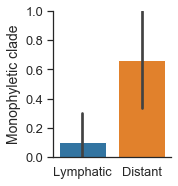

In [5]:
# Compare the monophyletic clades of lymphatic and distant mets (Fig. 1b)
compare_monophyletic_clades(overview_df, col_mono_lm, col_mono_dm, label='Monophyletic clade')
plot_monophyletic_clade(phyletic_df, y_col='MonophyleticClade', ylabel='Monophyletic clade', 
                        filepath='pnl_monophyletic_clade.pdf')

Monophyletic met clade of distant metastases: 83.333% (5/6)
Monophyletic met clade of lymphatic metastases: 20.000% (2/10)
Probability to observe a more imbalanced ratio by chance is 3.4965e-02.


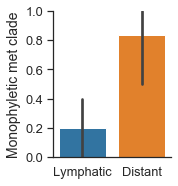

In [6]:
# Compare the monophyletic clades of lymphatic and distant mets when no primary tumor samples
# can be in a monophyletic clade (Supplementary Information)
compare_monophyletic_clades(overview_df, col_metmono_lm, col_metmono_dm, label='Monophyletic met clade')
plot_monophyletic_clade(phyletic_df, y_col='MetMonophyleticClade', ylabel='Monophyletic met clade', 
                        filepath='pnl_monophyletic_met_clade.pdf')

Number of lymphatic (mean: 3.700, #10) vs distant (mean 3.000, #6) metastases samples: Mann-Whitney U statistic 35.000, p-value 6.0720e-01


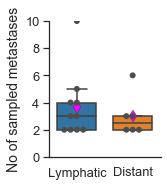

In [7]:
# Create boxplot to compare the number of samples of lymphatic and distant metastases (Fig. 1e)
# diamond marker for mean per group
meanpointprops = dict(marker='d', markeredgecolor='black', markeredgewidth=0.2,
                      markerfacecolor='magenta', markersize=9)

with sns.axes_style('white', {'axes.grid': False, 'grid.linestyle': u':', 
                              'xtick.labelsize': 13, 'ytick.labelsize': 10,
                              'ytick.major.size': 4.0}):
    
    f, ax = plt.subplots(figsize=(2.0, 2.5))
    sns.boxplot(x='Type', y='NoSamples', data=phyletic_df, palette=colors, whis=True,
                showmeans=True, meanprops=meanpointprops, orient="v", width=0.7, showfliers=False, 
                order=['Lymphatic', 'Distant'], ax=ax)
    sns.swarmplot(x='Type', y='NoSamples', data=phyletic_df, color=".3", size=6, 
                  order=['Lymphatic', 'Distant'], ax=ax)

    ax.yaxis.set_tick_params(which='major', left='on')
    ax.set(xlabel='');
    ax.set(ylim=[0, 10], ylabel='No of sampled metastases')
    sns.despine()
    plt.savefig('pnl_met_samples.pdf', dpi=150, bbox_inches='tight', transparent=True)
    
# calculate Mann-Whitney statistic
# t_stat, p_val = stats.ttest_ind(phyletic_df[phyletic_df.Type == 'Lymphatic'].NoSamples, 
#                                 phyletic_df[phyletic_df.Type == 'Distant'].NoSamples)

mwus = stats.mannwhitneyu(phyletic_df[phyletic_df.Type == 'Lymphatic'].NoSamples, 
                          phyletic_df[phyletic_df.Type == 'Distant'].NoSamples, alternative='two-sided')
            
print('Number of lymphatic (mean: {:.3f}, #{}) vs distant (mean {:.3f}, #{}) metastases samples: Mann-Whitney U statistic {:.3f}, p-value {:.4e}'.format(
    np.mean(phyletic_df[phyletic_df.Type == 'Lymphatic'].NoSamples), 
    len(phyletic_df[phyletic_df.Type == 'Lymphatic'].NoSamples), 
    np.mean(phyletic_df[phyletic_df.Type == 'Distant'].NoSamples), 
    len(phyletic_df[phyletic_df.Type == 'Distant'].NoSamples), 
    mwus[0], mwus[1]))